# Final Project: 某闯关类手游用户流失预测

## 1 案例简介  
  
手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

### ✍作业说明：

1. 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；  
2. 方法不限，使用学堂在线云平台进行评测，评价指标使用 AUC；  
3. 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等；  
4. 最终评分会参考达到的效果以及对所尝试方法的分析。

## 2 数据概览  
  
本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。  
  
对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。  
  
本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### 2.1 训练集 *train.csv* 
  
训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。


> 训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm


train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [2]:
# 检查是否有空数据
train_df.isna().any().any()

False

In [3]:
train_df['label'].value_counts()

label
0    5428
1    2730
Name: count, dtype: int64

### 2.2 验证集 *dev.csv*  
  
验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [4]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


In [5]:
# 检查是否有空数据
dev_df.isna().any().any()

False

### 2.3 测试集 *test.csv*  
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [6]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


In [7]:
# 检查是否有空数据
test_df.isna().any().any()

False

### 2.4 核心数据集 *level_seq.csv*  
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：  
  
* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；  
* `level_id`：关卡 id；  
* `f_success`：是否通关（1：通关，0：失败）；  
* `f_duration`：此次尝试所用的时间（单位 s）；  
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；  
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；  
* `time`：时间戳。

In [8]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


In [9]:
# 检查是否有空数据
seq_df.isna().any().any()

False

### 2.5 关卡统计数据集 *level_meta.csv*  
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：  
  
* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；  
* `f_avg_passrate`：平均通关率；  
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；  
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；  
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [10]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


In [11]:
# 检查是否有空数据
meta_df.isna().any().any()

False

## 3 特征工程

在特征工程设计中，选择分为两部分进行：
1. 根据 *level_seq.csv* 提取用户特征数据
    - 用户ID
    - 游戏次数
    - 通关率
    - 游戏总时间
    - 平均剩余步数
    - 总帮助次数
    - 登陆天数
2. 根据 *level_meta.csv* 提取关卡特征数据

    > 📣在提取关卡特征数据之后，根据设计的公式，计算出不同分值，合并到用户特征中
    - ***用户闯关时间分值：***
        用户参与关卡中，通关时间小于平均时间 **得0分** ，大于平均时间 **得1分**
    - ***用户重试次数分值：***
        用户参与关卡中，重试次数小于平均重试次数 **得0分** ，大于平均重试次数 **得1分**
    - ***用户通关率分值：***
        用户参与关卡中，通关成功 **得1-通关率的分值** ，通关失败 **得0分**
    - ***用户通关时间分值：***
        用户 **通关** 关卡中，通关时间小于平均时间 **得0分** ，大于平均时间 **得1分**


### 3.1 提取 *用户特征*
- 用户ID
- 游戏次数
- 通关率
- 游戏总时间
- 平均剩余步数
- 总帮助次数
- 登陆天数

In [12]:
'''
提取用户特征测试：
    根据训练集第一个用户的数据，进行特征提取
'''
user_features = []
user_id = train_df['user_id'][0]

# 提取该用户的信息到user_df
user_df = seq_df[seq_df['user_id'] == user_id]

# 添加用户id
user_features.append(user_id)

# 添加用户游戏次数
user_features.append(len(user_df))

# 添加用户通关率
user_df_succ = user_df[user_df['f_success']==1]
success_rate = round(len(user_df_succ) / len(user_df), 6)
user_features.append(success_rate)

# 添加用户游戏总时间
duration_all = user_df['f_duration'].sum()
user_features.append(duration_all)

# 添加平均剩余步数
reststep_mean = round(user_df['f_reststep'].mean(),6)
user_features.append(reststep_mean)

# 添加累积帮助次数
times_help = user_df['f_help'].sum()
user_features.append(times_help)

# 登陆天数
user_time = pd.to_datetime(user_df['time'])
days = user_time.dt.date.nunique()
user_features.append(days)

user_features

[2774, 215, 0.632558, 25398.0, 0.189056, 18, 4]

In [13]:
# 打印单用户数据
user_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
617,2774,1,1,50.0,0.500000,0,2020-02-01 00:02:21
618,2774,2,1,63.0,0.814815,0,2020-02-01 00:05:22
619,2774,3,1,71.0,0.720000,0,2020-02-01 00:07:25
620,2774,4,1,45.0,0.733333,0,2020-02-01 00:09:39
621,2774,5,1,78.0,0.375000,0,2020-02-01 00:11:36
...,...,...,...,...,...,...,...
827,2774,134,0,145.0,0.000000,0,2020-02-04 22:53:41
828,2774,134,0,129.0,0.000000,0,2020-02-04 22:55:51
829,2774,134,0,262.0,0.000000,0,2020-02-04 23:00:15
830,2774,134,0,164.0,0.000000,0,2020-02-04 23:03:00


In [14]:
def Features_Contrust_User(df):
    features = []

    for user_id in tqdm(df['user_id'],desc='Processing Users'):
        user_features = []
        # 提取该用户的信息到user_df
        user_df = seq_df[seq_df['user_id'] == user_id]

        # 添加用户id
        user_features.append(user_id)

        # 添加用户游戏次数
        user_features.append(len(user_df))

        # 添加用户通关率
        user_df_succ = user_df[user_df['f_success']==1]
        success_rate = round(len(user_df_succ) / len(user_df), 6)
        user_features.append(success_rate)

        # 添加用户游戏总时间
        duration_all = user_df['f_duration'].sum()
        user_features.append(duration_all)

        # 添加平均剩余步数
        reststep_mean = round(user_df['f_reststep'].mean(),6)
        user_features.append(reststep_mean)

        # 添加累积帮助次数
        times_help = user_df['f_help'].sum()
        user_features.append(times_help)

        # 登陆天数
        user_time = pd.to_datetime(user_df['time'], format="%Y-%m-%d %H:%M:%S")
        days = user_time.dt.date.nunique()
        user_features.append(days)

        features.append(user_features)

    features_df = pd.DataFrame(features)
    features_df.columns =['user_id','游戏次数','通关率','游戏总时间','平均剩余步数比','累积帮助次数','登陆天数']
    return features_df

Features_Contrust_User(dev_df)

Processing Users: 100%|██████████| 2658/2658 [00:05<00:00, 510.69it/s]


,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数
0,10932,222,0.504505,41146.0,0.143857,20,4
1,10933,86,0.604651,9482.0,0.189069,4,3
2,10934,97,0.731959,10707.0,0.265445,7,3
3,10935,20,0.750000,1811.0,0.339879,2,3
4,10936,229,0.524017,33288.0,0.115141,22,4
...,...,...,...,...,...,...,...
2653,13585,248,0.451613,27237.0,0.119008,12,3
2654,13586,311,0.446945,38920.0,0.108392,16,3
2655,13587,20,0.700000,2195.0,0.228793,0,2
2656,13588,28,0.964286,2118.0,0.441202,0,2


### 3.2 提取 *关卡特征*

🔔根据`level_meta.csv`包含的关卡数据，计算不同类型的用户分数，合并到用户特征中
- 🔖***用户闯关时间分值：*** 

    用户参与关卡中，通关时间小于平均时间 **得0分** ，大于平均时间 **得1分**
- 🔖***用户重试次数分值：*** 

    用户参与关卡中，重试次数小于平均重试次数 **得0分** ，大于平均重试次数 **得1分**
- 🔖***用户通关率分值：*** 

    用户参与关卡中，通关成功 **得1-通关率的分值** ，通关失败 **得0分**
- 🔖***用户通关时间分值：***

    用户 **通关** 关卡中，通关时间小于平均时间 **得0分** ，大于平均时间 **得1分**



In [15]:

user_scores = []
user_id = train_df['user_id'][0]

# 提取该用户的信息到user_df
user_df = seq_df[seq_df['user_id'] == user_id]

# 添加用户id
user_scores.append(user_id)

scores_duration = 0
scores_win_duration = 0
scores_passrate = 0
for item,row in user_df.iterrows():
    level_id = row['level_id']
    level_df = (meta_df[meta_df['level_id'] == level_id]).iloc[0]
    
    # 用户闯关时间分值
    my_duration = row['f_duration']
    avg_duration = level_df['f_avg_duration']
    score_duration = 1 if my_duration> avg_duration else 0
    scores_duration+=score_duration

    # 用户通关率分值
    my_suc = row['f_success']
    avg_duration = level_df['f_avg_passrate']
    score_passrate = 1-avg_duration if my_suc==1 else 0
    scores_passrate += score_passrate

    # 用户通关时间分值
    if(my_suc == 1):
        my_win_duration = row['f_duration']
        avg_win_duration = level_df['f_avg_win_duration']
        score_win_duration = 1 if my_win_duration> avg_win_duration else 0
        scores_win_duration+=score_win_duration

scores_retrytimes = 0
# 用户重试次数分值
my_retrytimes = user_df['level_id'].value_counts()
for level, count in my_retrytimes.items():
    level_df = (meta_df[meta_df['level_id'] == level]).iloc[0]
    avg_retrytime = level_df['f_avg_retrytimes']
    score_retrytime = 1 if count > avg_retrytime else 0
    scores_retrytimes+=score_retrytime

scores_duration,scores_retrytimes,scores_passrate,scores_win_duration

(16, 112, 29.332141329431998, 60)

In [16]:

def Features_Contrust_Score(df):
    features = []
    
    for user_id in tqdm(df['user_id'], desc='Processing Users'):
        user_scores = []

        # 提取该用户的信息到user_df
        user_df = seq_df[seq_df['user_id'] == user_id]

        # 添加用户id
        user_scores.append(user_id)

        scores_duration = 0
        scores_win_duration = 0
        scores_passrate = 0
        scores_retrytimes = 0
        for _,row in user_df.iterrows():
            level_id = row['level_id']
            level_df = (meta_df[meta_df['level_id'] == level_id]).iloc[0]
            
            # 用户闯关时间分值
            my_duration = row['f_duration']
            avg_duration = level_df['f_avg_duration']
            score_duration = 1 if my_duration> avg_duration else 0
            scores_duration+=score_duration

            # 用户通关率分值
            my_suc = row['f_success']
            avg_duration = level_df['f_avg_passrate']
            score_passrate = 1-avg_duration if my_suc==1 else 0
            scores_passrate += score_passrate

            # 用户通关时间分值
            if(my_suc == 1):
                my_win_duration = row['f_duration']
                avg_win_duration = level_df['f_avg_win_duration']
                score_win_duration = 1 if my_win_duration> avg_win_duration else 0
                scores_win_duration+=score_win_duration
        
        user_scores.append(scores_duration)
        user_scores.append(scores_win_duration)
        user_scores.append(scores_passrate)

        # 用户重试次数分值
        my_retrytimes = user_df['level_id'].value_counts()
        for level, count in my_retrytimes.items():
            level_df = (meta_df[meta_df['level_id'] == level]).iloc[0]
            avg_retrytime = level_df['f_avg_retrytimes']
            score_retrytime = 1 if count > avg_retrytime else 0
            scores_retrytimes+=score_retrytime
        user_scores.append(scores_retrytimes)
    
        features.append(user_scores)
    
    features_df = pd.DataFrame(features)
    features_df.columns =['user_id','用户闯关时间分值','用户通关率分值','用户通关时间分值','用户重试次数分值']
    return features_df

Features_Contrust_Score(dev_df)

Processing Users: 100%|██████████| 2658/2658 [01:38<00:00, 26.99it/s]


,user_id,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值
0,10932,51,99,23.017459,108
1,10933,16,24,5.818085,53
2,10934,5,37,9.240510,69
3,10935,6,8,0.675395,15
4,10936,22,86,25.570134,113
...,...,...,...,...,...
2653,13585,3,20,21.389009,111
2654,13586,14,88,30.931455,130
2655,13587,0,5,5.035768,8
2656,13588,1,7,1.587732,27


## 4 数据集构建

### 4.1 训练集

In [17]:
import warnings

# 训练集 用户数据
train_features_user_df = Features_Contrust_User(train_df)
train_features_user_df

Processing Users: 100%|██████████| 8158/8158 [00:14<00:00, 559.99it/s]


,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数
0,2774,215,0.632558,25398.0,0.189056,18,4
1,2775,111,0.738739,18839.0,0.258456,14,3
2,2776,69,0.637681,6119.0,0.186543,1,3
3,2777,286,0.506993,40808.0,0.124245,4,4
4,2778,162,0.672840,32045.0,0.299450,9,3
...,...,...,...,...,...,...,...
8153,10927,350,0.505714,34697.0,0.166471,10,4
8154,10928,50,1.000000,4073.0,0.471203,3,2
8155,10929,243,0.469136,28858.0,0.117959,14,3
8156,10930,39,0.948718,6120.0,0.380187,6,2


In [18]:
# 训练集 关卡数据
train_features_score_df = Features_Contrust_Score(train_df)
train_features_score_df

Processing Users: 100%|██████████| 8158/8158 [04:53<00:00, 27.78it/s]


,user_id,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值
0,2774,16,60,29.332141,112
1,2775,37,67,12.707471,81
2,2776,1,7,7.606755,46
3,2777,14,79,38.681589,130
4,2778,45,87,20.940867,90
...,...,...,...,...,...
8153,10927,12,36,55.843120,147
8154,10928,2,11,5.034296,48
8155,10929,9,32,23.423420,114
8156,10930,21,30,2.612521,37


In [19]:
# 合并训练集
train_features_df = pd.merge(train_features_user_df,train_features_score_df,on='user_id')
train_features_df['label'] = train_df['label']
train_features_df

,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值,label
0,2774,215,0.632558,25398.0,0.189056,18,4,16,60,29.332141,112,0
1,2775,111,0.738739,18839.0,0.258456,14,3,37,67,12.707471,81,0
2,2776,69,0.637681,6119.0,0.186543,1,3,1,7,7.606755,46,1
3,2777,286,0.506993,40808.0,0.124245,4,4,14,79,38.681589,130,0
4,2778,162,0.672840,32045.0,0.299450,9,3,45,87,20.940867,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8153,10927,350,0.505714,34697.0,0.166471,10,4,12,36,55.843120,147,1
8154,10928,50,1.000000,4073.0,0.471203,3,2,2,11,5.034296,48,1
8155,10929,243,0.469136,28858.0,0.117959,14,3,9,32,23.423420,114,0
8156,10930,39,0.948718,6120.0,0.380187,6,2,21,30,2.612521,37,1


### 4.2 验证集

In [20]:
# 验证集 用户数据
dev_features_user_df = Features_Contrust_User(dev_df)
dev_features_user_df

Processing Users: 100%|██████████| 2658/2658 [00:04<00:00, 554.20it/s]


,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数
0,10932,222,0.504505,41146.0,0.143857,20,4
1,10933,86,0.604651,9482.0,0.189069,4,3
2,10934,97,0.731959,10707.0,0.265445,7,3
3,10935,20,0.750000,1811.0,0.339879,2,3
4,10936,229,0.524017,33288.0,0.115141,22,4
...,...,...,...,...,...,...,...
2653,13585,248,0.451613,27237.0,0.119008,12,3
2654,13586,311,0.446945,38920.0,0.108392,16,3
2655,13587,20,0.700000,2195.0,0.228793,0,2
2656,13588,28,0.964286,2118.0,0.441202,0,2


In [21]:
# 验证集 关卡数据
dev_features_score_df = Features_Contrust_Score(dev_df)
dev_features_score_df

Processing Users: 100%|██████████| 2658/2658 [01:36<00:00, 27.51it/s]


,user_id,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值
0,10932,51,99,23.017459,108
1,10933,16,24,5.818085,53
2,10934,5,37,9.240510,69
3,10935,6,8,0.675395,15
4,10936,22,86,25.570134,113
...,...,...,...,...,...
2653,13585,3,20,21.389009,111
2654,13586,14,88,30.931455,130
2655,13587,0,5,5.035768,8
2656,13588,1,7,1.587732,27


In [22]:
# 合并验证集
dev_features_df = pd.merge(dev_features_user_df,dev_features_score_df,on='user_id')
dev_features_df['label'] = dev_df['label']
dev_features_df

,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值,label
0,10932,222,0.504505,41146.0,0.143857,20,4,51,99,23.017459,108,0
1,10933,86,0.604651,9482.0,0.189069,4,3,16,24,5.818085,53,1
2,10934,97,0.731959,10707.0,0.265445,7,3,5,37,9.240510,69,0
3,10935,20,0.750000,1811.0,0.339879,2,3,6,8,0.675395,15,1
4,10936,229,0.524017,33288.0,0.115141,22,4,22,86,25.570134,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2653,13585,248,0.451613,27237.0,0.119008,12,3,3,20,21.389009,111,0
2654,13586,311,0.446945,38920.0,0.108392,16,3,14,88,30.931455,130,0
2655,13587,20,0.700000,2195.0,0.228793,0,2,0,5,5.035768,8,0
2656,13588,28,0.964286,2118.0,0.441202,0,2,1,7,1.587732,27,1


### 4.3 测试集

In [23]:
# 测试集 用户数据
test_features_user_df = Features_Contrust_User(test_df)
test_features_user_df

Processing Users:   0%|          | 0/2773 [00:00<?, ?it/s]

Processing Users: 100%|██████████| 2773/2773 [00:05<00:00, 533.79it/s]


,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数
0,1,395,0.263291,38860.0,0.060526,8,4
1,2,237,0.514768,20190.0,0.150546,20,4
2,3,230,0.608696,22291.0,0.235325,14,2
3,4,107,0.532710,13234.0,0.143748,8,4
4,5,238,0.420168,29454.0,0.118816,20,4
...,...,...,...,...,...,...,...
2768,2769,41,0.829268,3294.0,0.324696,3,3
2769,2770,411,0.501217,41576.0,0.147572,18,4
2770,2771,255,0.701961,24327.0,0.198157,15,4
2771,2772,87,0.632184,10432.0,0.211336,1,2


In [24]:
# 测试集 关卡数据
test_features_score_df = Features_Contrust_Score(test_df)
test_features_score_df

Processing Users: 100%|██████████| 2773/2773 [01:38<00:00, 28.24it/s]


,user_id,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值
0,1,9,28,19.660024,106
1,2,1,10,28.858450,113
2,3,4,30,30.559213,131
3,4,22,35,6.669461,58
4,5,10,62,18.637362,105
...,...,...,...,...,...
2768,2769,2,4,2.208893,35
2769,2770,1,37,67.168588,164
2770,2771,2,40,50.195715,136
2771,2772,9,33,6.195868,57


In [25]:
# 合并测试集
test_features_df = pd.merge(test_features_user_df,test_features_score_df,on='user_id')
test_features_df

,user_id,游戏次数,通关率,游戏总时间,平均剩余步数比,累积帮助次数,登陆天数,用户闯关时间分值,用户通关率分值,用户通关时间分值,用户重试次数分值
0,1,395,0.263291,38860.0,0.060526,8,4,9,28,19.660024,106
1,2,237,0.514768,20190.0,0.150546,20,4,1,10,28.858450,113
2,3,230,0.608696,22291.0,0.235325,14,2,4,30,30.559213,131
3,4,107,0.532710,13234.0,0.143748,8,4,22,35,6.669461,58
4,5,238,0.420168,29454.0,0.118816,20,4,10,62,18.637362,105
...,...,...,...,...,...,...,...,...,...,...,...
2768,2769,41,0.829268,3294.0,0.324696,3,3,2,4,2.208893,35
2769,2770,411,0.501217,41576.0,0.147572,18,4,1,37,67.168588,164
2770,2771,255,0.701961,24327.0,0.198157,15,4,2,40,50.195715,136
2771,2772,87,0.632184,10432.0,0.211336,1,2,9,33,6.195868,57


### 4.4 数据归一化
- **归一化：Min-Max Normalization**  
  - $\frac{x_{i}-min(x_i)}{max(x_i)-min(x_i)}$ 

In [26]:
''' 
函数说明：对数据进行归一化
Parameters:
    dataSet - 特征矩阵
Returns:
    normDataSet - 归一化后的特征矩阵
'''
def autoNorm(dataSet):
    # 获得数据的最小值
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    # 最大值和最小值的范围
    ranges = maxVals - minVals
    # shape(dataSet)返回dataSet的矩阵行列数
    normDataSet = np.zeros(np.shape(dataSet))
    # 返回dataSet的行数
    m = dataSet.shape[0]
    # 原始值减去最小值
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    # 除以最大和最小值的差,得到归一化数据
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    # 返回归一化数据结果,数据范围,最小值
    return normDataSet

In [27]:
# 训练集
train_features = np.array(train_features_df.iloc[:, 1:11])
train_features = autoNorm(train_features) # 归一化
train_labels = train_features_df.iloc[:, -1].values
# 验证集
dev_features = np.array(dev_features_df.iloc[:, 1:11])
dev_features = autoNorm(dev_features) # 归一化
dev_labels = dev_features_df.iloc[:, -1].values
train_features.shape,train_labels.shape,dev_features.shape,dev_labels.shape

((8158, 10), (8158,), (2658, 10), (2658,))

In [28]:
# 测试集
test_features = np.array(test_features_df.iloc[:, 1:11])
test_features = autoNorm(test_features) # 归一化
test_features.shape

(2773, 10)

## 5 模型构建

In [29]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [52]:
p_list = [] # 记录模型预测结果（0/1）
pro_list = [] # 记录模型预测结果（probability）

### 5.1 决策树

In [53]:
parameters = {'criterion':['entropy', 'gini'], 
              'max_depth': range(1, 6), 
              'min_samples_split': [10, 50, 100, 200, 500, 1000]} # 定义需要遍历的参数
              
clf = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(clf, parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=4) # 传入模型和要遍历的参数
grid_search.fit(train_features,train_labels) # 在所有数据上搜索参数
print(grid_search.best_score_, grid_search.best_params_) # 输出最佳指标和最佳参数


Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.7391579056515309 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 10}


In [54]:
clf = tree.DecisionTreeClassifier(**grid_search.best_params_)
clf.fit(train_features,train_labels) # 在训练集上训练
p_test = clf.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
pro_test = clf.predict_proba(dev_features)

test_acc = accuracy_score(p_test, dev_labels) # 将测试预测值与测试集标签对比获得准确率
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))

p_list.append(p_test)
pro_list.append(pro_test)

[0 0 0 ... 1 1 1]
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7663


### 5.2 贝叶斯学习

In [55]:
for NB in [BernoulliNB(), MultinomialNB(), ComplementNB()]: # 测试三种类型的朴素贝叶斯
    NB.fit(train_features,train_labels) # 在训练集上训练
    p_test = NB.predict(dev_features) # 在测试集上预测，获得预测值
    pro_test = NB.predict_proba(dev_features)
    test_acc = accuracy_score(dev_labels, p_test) # 准确率
    test_prec = precision_score(dev_labels, p_test) # 精准率
    test_rec = recall_score(dev_labels, p_test) # 召回率
    test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
    print(NB)
    print(p_test)
    print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
    print('>> AUC: {:.4f}'.format(test_AUC))


BernoulliNB()
[0 0 0 ... 1 1 1]
>> accuracy: 0.7385, precision: 0.6366, recall: 0.5327
>> AUC: 0.7073
MultinomialNB()
[0 0 0 ... 0 0 0]
>> accuracy: 0.6731, precision: 0.7162, recall: 0.0588
>> AUC: 0.7786
ComplementNB()
[0 0 0 ... 1 1 1]
>> accuracy: 0.7400, precision: 0.6067, recall: 0.6626
>> AUC: 0.7786


In [56]:
NB = ComplementNB()
NB.fit(train_features,train_labels)
p_test = NB.predict(dev_features)
pro_test = NB.predict_proba(dev_features)

p_list.append(p_test)
pro_list.append(pro_test)

### 5.3 k-邻近

In [57]:
parameters = {'n_neighbors': range(1, 30),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski']}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(KNN, parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=4)
grid_search.fit(train_features,train_labels) # 在所有数据上搜索参数
print(grid_search.best_score_, grid_search.best_params_) # 输出最佳指标和最佳参数

Fitting 5 folds for each of 232 candidates, totalling 1160 fits
0.7329049001574879 {'metric': 'chebyshev', 'n_neighbors': 29, 'weights': 'uniform'}


In [58]:
KNN = KNeighborsClassifier(**grid_search.best_params_)  # 取最佳参数
KNN.fit(train_features,train_labels) # 在训练集上训练
p_test = KNN.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
pro_test = KNN.predict_proba(dev_features)
test_acc = accuracy_score(p_test, dev_labels) # 将测试预测值与测试集标签对比获得准确率
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])

print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))

p_list.append(p_test)
pro_list.append(pro_test)

[0 0 0 ... 1 1 1]
>> accuracy: 0.7348, precision: 0.4917, recall: 0.6420
>> AUC: 0.7712


### 5.4 SVM

In [59]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid_search  = GridSearchCV(SVC(),param_grid,scoring='accuracy', cv=5, verbose=100, n_jobs=4)
grid_search.fit(train_features,train_labels)
print(grid_search.best_score_, grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.7401390491819045 {'C': 1, 'gamma': 0.01}


In [60]:
SVM = SVC(probability=True,**grid_search.best_params_)  # 取最佳参数
SVM.fit(train_features,train_labels) # 在训练集上训练
p_test = SVM.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
pro_test = SVM.predict_proba(dev_features)
test_acc = accuracy_score(p_test, dev_labels) 
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])

print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))

p_list.append(p_test)
pro_list.append(pro_test)

[0 0 0 ... 1 1 1]
>> accuracy: 0.7397, precision: 0.5250, recall: 0.6418
>> AUC: 0.7801


In [61]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [62]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(dev_labels, pro_list[i][:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

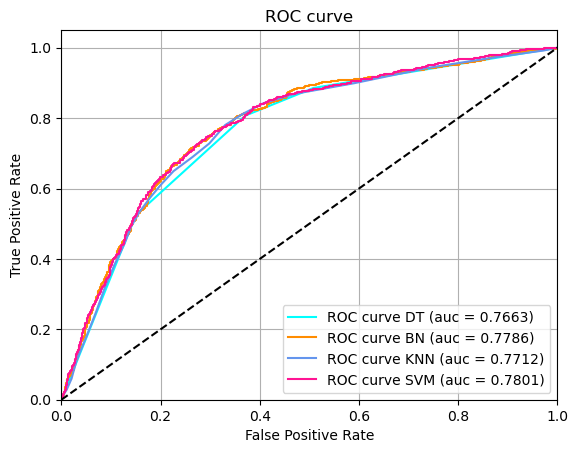

In [63]:
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue","deeppink"])
models = cycle(["DT","BN","KNN","SVM"])
for i, color,model in zip(range(4), colors, models):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve {0} (auc = {1:0.4f})".format(model, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid("open")
plt.show()

### 5.5 集成学习

In [64]:
p_list_Adaboost = [] # 记录Adaboost+模型预测结果（0/1）
pro_list_Adaboost = [] # 记录Adaboost+模型预测结果（probability）

In [65]:
for baseclf in [tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50),
                BernoulliNB(),
                SVC(C=1,  gamma=0.01,probability=True)]:
    Adaboost_ = AdaBoostClassifier(baseclf,algorithm='SAMME')
    Adaboost_.fit(train_features,train_labels)
    p_test = Adaboost_.predict(dev_features)
    p_list_Adaboost.append(p_test)
    pro_test = Adaboost_.predict_proba(dev_features)
    pro_list_Adaboost.append(pro_test)
    
    test_acc = accuracy_score(p_test, dev_labels)
    test_prec = precision_score(p_test, dev_labels) 
    test_rec = recall_score(p_test, dev_labels)
    test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
    
    print(baseclf)
    print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
    print('>> AUC: {:.4f}'.format(test_AUC))

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)
>> accuracy: 0.7216, precision: 0.3929, recall: 0.6472
>> AUC: 0.7811
BernoulliNB()
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7072
SVC(C=1, gamma=0.01, probability=True)
>> accuracy: 0.6610, precision: 0.0000, recall: 0.0000
>> AUC: 0.5000


d:\Software\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
for i,model in enumerate(["Adaboost + D_T","Adaboost + B_N","Adaboost + SVM"]):
    auc = roc_auc_score(dev_labels,pro_list_Adaboost[i][:,1])
    print("{0} model: \n>> AUC = {1:.4f}".format(model,auc))

Adaboost + D_T model: 
>> AUC = 0.7811
Adaboost + B_N model: 
>> AUC = 0.7072
Adaboost + SVM model: 
>> AUC = 0.5000


## 6 提交测试
  
提交文件需要对测试集中每一个用户给出预测流失的概率，每行包括一个`ID`（和 test.csv 中的`user_id`对应）以及预测的概率`Prediction`（0-1的浮点数），用逗号分隔。示例提交格式如下：  
  
```  
ID,Prediction  
1,0.9  
2,0.45  
3,0.78  
...  
```

In [50]:
base = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)
TEST = Adaboost_ = AdaBoostClassifier(base,algorithm='SAMME')
TEST.fit(train_features,train_labels)
pro_test = TEST.predict_proba(test_features)

test_df['Prediction'] = pro_test[:,1]
test_df.rename(columns={'user_id':'ID'},inplace=True)
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
ID,1.000000,2.00000,3.000000,4.000000,5.000000,6.00000,7.000000,8.000000,9.000000,10.000000,...,2764.000000,2765.000000,2766.000000,2767.000000,2768.000000,2769.000000,2770.000000,2771.00000,2772.000000,2773.000000
Prediction,0.297698,0.38273,0.485057,0.359337,0.324984,0.37153,0.520123,0.308808,0.289494,0.504076,...,0.376291,0.442527,0.397151,0.569864,0.508034,0.498919,0.355091,0.36625,0.464252,0.477353


In [51]:
# DataFrame 转 .csv
test_df.to_csv(r'./result.csv',index=False)

## Tips  
  
* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；  
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；  
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；  
* 集成多种模型往往能达到更优的效果；  
* 可以使用各种开源工具。